In [1]:
%pylab inline
import nltk
import urllib.request
import math
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

Populating the interactive namespace from numpy and matplotlib


We take all five books of Moses from the Bible and seperate them into chapters.

In [2]:
book_names = ["The First Book of Moses:  Called Genesis",
          "The Second Book of Moses:  Called Exodus",
          "The Third Book of Moses:  Called Leviticus",
          "The Fourth Book of Moses:  Called Numbers",
          "The Fifth Book of Moses:  Called Deuteronomy",
          "The Book of Joshua"] # last one is not used

bible = open('raamattu.txt','r').read()

for name in book_names:
    bible = bible.replace(name,"===")
    
books = []
for book in bible.split("===")[1:-1]:
    chapter = re.split('(\d+):\d+\s', ' '.join(book.split()))
    chapters = {}
    for i,txt in enumerate(chapter[1:]):
        if i % 2:
            if c in chapters:
                chapters[c] += ' ' + txt
            else:
                chapters[c] = txt
        else:
            c = txt
    books.append(list(chapters.values()))
print('Num of books:', len(books))
for i in range(len(books)):
    print(f'Num of chapters in {i+1}. book:', len(books[i]))

Num of books: 5
Num of chapters in 1. book: 50
Num of chapters in 2. book: 40
Num of chapters in 3. book: 27
Num of chapters in 4. book: 36
Num of chapters in 5. book: 34


In [3]:
import nltk
#nltk.download('stopwords')

from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))

Clean function filters out all special characters and removes stop words and lemmatizes words.

In [4]:
def clean(text_arr, stopwords=[], filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\r1234567890'):
    lemmatizer = WordNetLemmatizer()
    result = []
    for sample in text_arr:
        sample = sample.lower()
        for c in filters:
            sample = sample.replace(c, '')            
        for word in stopwords:
            sample = sample.replace(f' {word} ', ' ', )
        sample = lemmatizer.lemmatize(sample)
        #sample = ' '.join(sample.split())            
        result.append(sample.split())
    return result

In [5]:
for i in range(len(books)):
    books[i] = clean(books[i], stopwords)

In [6]:
positive_words = open('positive-words.txt', 'r').read().split()
negative_words = open('negative-words.txt', 'r').read().split()

This function counts the number of same words in two list.

In [7]:
def count_same_words(a, b):
    count = 0
    for word in set(a) & set(b):
        count += a.count(word)
    return count

Here we count the number of positive/negative/neutral words in each chapter.

In [8]:
pos_neg_neu = []
for i in range(len(books)):
    for j in range(len(books[i])):
        pos = count_same_words(books[i][j], positive_words)
        neg = count_same_words(books[i][j], negative_words)
        neu = len(books[i][j]) - pos - neg
        pos_neg_neu.append((pos,neg,neu))
    
for i, pnn in enumerate(pos_neg_neu):
    print(f'{i+1}: chapters {pnn}')

1: chapters (18, 6, 358)
2: chapters (11, 7, 264)
3: chapters (6, 16, 348)
4: chapters (4, 10, 308)
5: chapters (2, 10, 274)
6: chapters (8, 11, 261)
7: chapters (10, 7, 260)
8: chapters (7, 6, 266)
9: chapters (10, 13, 270)
10: chapters (4, 0, 232)
11: chapters (2, 7, 326)
12: chapters (11, 5, 242)
13: chapters (8, 6, 189)
14: chapters (3, 3, 276)
15: chapters (11, 10, 217)
16: chapters (6, 10, 195)
17: chapters (26, 6, 303)
18: chapters (19, 25, 364)
19: chapters (7, 22, 495)
20: chapters (5, 8, 236)
21: chapters (12, 9, 354)
22: chapters (8, 3, 302)
23: chapters (3, 18, 224)
24: chapters (61, 9, 821)
25: chapters (6, 11, 327)
26: chapters (18, 11, 393)
27: chapters (29, 24, 581)
28: chapters (9, 4, 280)
29: chapters (14, 5, 380)
30: chapters (8, 7, 506)
31: chapters (7, 28, 662)
32: chapters (6, 8, 371)
33: chapters (12, 2, 222)
34: chapters (8, 9, 346)
35: chapters (2, 11, 299)
36: chapters (0, 7, 412)
37: chapters (5, 11, 412)
38: chapters (2, 8, 370)
39: chapters (15, 17, 225)
40

Here we calculate the metrics.

In [9]:
dic = []

for i, pnn in enumerate(pos_neg_neu):
    pos, neg, neu = pnn
    total = sum(pnn)
    score = pos-neg
    
    positiveness = math.log((pos+1)/(neg+1))
    
    affection = 1-neu/total
    dic.append((pos,neg,neu, score,positiveness,affection))
    
dic = np.array(dic)

Caluculates the sliding average of array.

In [10]:
def smooth(arr):
    arr = [0]*3 + arr + [0]*3
    result = []
    for i in range(3, len(arr) - 3):
        result.append(sum(arr[i-3:i+4])/7)
    return result

Plot the metrics.
* Vertical red dashed lines indicate where the book changes.

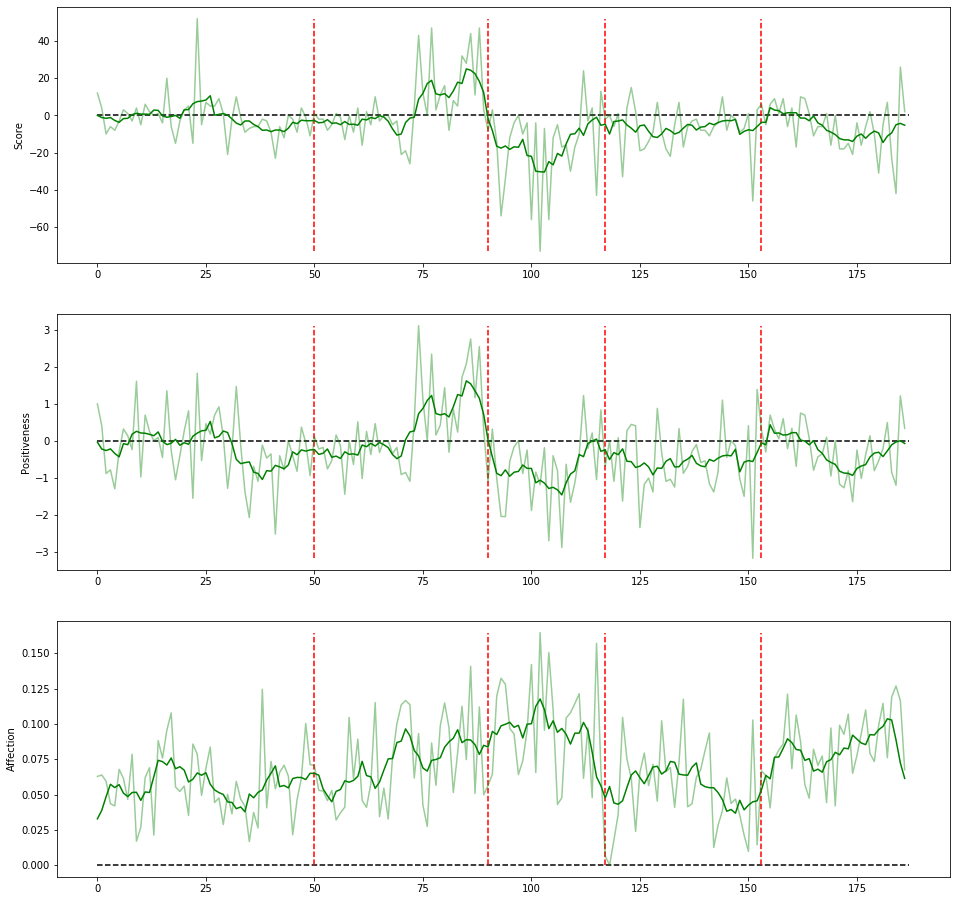

In [11]:
fig, axes = plt.subplots(3, figsize=(16,16))
names = ['Score', 'Positiveness', 'Affection']
for i in range(3):
    axes[i].set_ylabel(names[i])
    axes[i].plot(dic[:,i+3],'g-', alpha=0.4)
    axes[i].plot(smooth(list(dic[:,i+3])),'g-')
    axes[i].hlines(0, 0, len(dic), 'k', ls='dashed')
    s = 0
    for b in books[:-1]:
        s += len(b)
        axes[i].vlines(s, min(dic[:,i+3]), max(dic[:,i+3]), 'r', ls='dashed')
plt.show()